In [1]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import scipy
import pickle
import pandas as pd
import seaborn as sns
import math
import numpy.linalg as lg
import scipy.linalg as slg

from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from sklearn.metrics.cluster import adjusted_rand_score as ri
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans, SpectralClustering
import itertools
from scipy.sparse import csr_matrix
import scipy.io 

%load_ext autoreload
%autoreload 2

#### Tools for plotting and evaluation

In [2]:
def purity_score(y_true, y_pred):
    """Purity score
        Args:
            y_true(np.ndarray): n*1 matrix Ground truth labels
            y_pred(np.ndarray): n*1 matrix Predicted clusters

        Returns:
            float: Purity score
    """
    # matrix which will hold the majority-voted labels
    y_voted_labels = np.zeros(y_true.shape)
    # Ordering labels
    ## Labels might be missing e.g with set like 0,2 where 1 is missing
    ## First find the unique labels, then map the labels to an ordered set
    ## 0,2 should become 0,1
    labels = np.unique(y_true)
    ordered_labels = np.arange(labels.shape[0])
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
    # Update unique labels
    labels = np.unique(y_true)
    # We set the number of bins to be n_classes+2 so that 
    # we count the actual occurence of classes between two consecutive bins
    # the bigger being excluded [bin_i, bin_i+1[
    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)

    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        # Find the most present label in the cluster
        winner = np.argmax(hist)
        y_voted_labels[y_pred==cluster] = winner

    return accuracy_score(y_true, y_voted_labels)


def accuracy_clustering(y_true, y_pred):
    
    # Ordering labels
    labels = np.unique(y_true)
    ordered_labels = np.arange(labels.shape[0])
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
    labels = np.unique(y_true)
    
    scores = []
    
    # Try all the possible permutations
    permutations = list(itertools.permutations(labels))
    for perm in permutations:
        y_permuted = np.zeros_like(y_true)
        for i,k in enumerate(perm):
            y_permuted[y_pred==k] = labels[i]
        score = accuracy_score(y_true, y_permuted)
        scores.append(score)
    
    return max(scores)

In [3]:
def print_evaluation(y_true, L, K):

    _, V   = scipy.linalg.eigh(L)
    E      = V[:,:K]
    y = KMeans(K, random_state=42).fit_predict(E)

    acc_spec = accuracy_clustering(y_true, y)
    pu_spec        = purity_score(y_true, y)
    nmi_score_spec = nmi(y_true.ravel(), y.ravel())#, average_method='geometric')
    ri_score_spec  = ri(y_true.ravel(), y.ravel())

    print('Accuracy', acc_spec, 'Purity', pu_spec, 'NMI', nmi_score_spec, 'RI', ri_score_spec)
    return y

In [4]:
def print_evaluation_from_embeddings(y_true, embeddings, K):

    y = KMeans(K, random_state=42).fit_predict(embeddings)

    acc_spec = accuracy_clustering(y_true, y)
    pu_spec        = purity_score(y_true, y)
    nmi_score_spec = nmi(y_true.ravel(), y.ravel())#, average_method='geometric')
    ri_score_spec  = ri(y_true.ravel(), y.ravel())

    print('Accuracy', acc_spec, 'Purity', pu_spec, 'NMI', nmi_score_spec, 'RI', ri_score_spec)
    return y

## -- Graph generation

In [5]:
def read_data(name):
    data_file = scipy.io.loadmat('data/'+name+'.mat')
    
    input_data = data_file['data']
    labels     = (data_file['truelabel'][0][0])
    
    nb_view    = len(input_data[0])
    N          = labels.ravel().shape[0]
    
    adjancency = np.zeros((N, N, nb_view))
    laplacian  = np.zeros((N, N, nb_view))
    
    for i in range(nb_view): 
        aux = input_data[0][i]
        if type(aux) is scipy.sparse.csc.csc_matrix:
            aux = aux.toarray()
        adjancency[:,:,i] = build_kneighbors(aux.transpose([1,0]), n_neighbors=5)
        laplacian[:,:,i] = sgwt_raw_laplacian(adjancency[:,:,i])
        
        if i==0:
            signal = aux.transpose([1,0])
        else:                           
            signal = np.concatenate((signal, aux.transpose([1,0])), axis=1)

    y_true = labels.ravel()  
    K      = len(np.unique(y_true))
    
    n_neighbors = 5
    
    return adjancency, laplacian, signal, y_true, K, n_neighbors

In [6]:
def sgwt_raw_laplacian(B):
    B         = B.T;
    N         = B.shape[0] 
    degrees   = B.sum(axis=1)
    diagw     = np.diag(B)

    nj2,ni2   = B.nonzero() 
    w2        = np.extract(B!=0,B)
    ndind     = (ni2!=nj2).nonzero()
    ni        = ni2[ndind]
    nj        = nj2[ndind]
    w         = w2[ndind]
    di        = np.arange(0,N)
    #dL        = 1 - diagw / degrees       
    #dL[degrees==0] = 0
    #ndL       = -w / (np.sqrt(degrees[ni]*degrees[ni])).flatten() 
    L         = csr_matrix((np.hstack((-w,degrees-diagw)), (np.hstack((ni,di)), np.hstack((nj,di)))), shape=(N, N)).toarray()

    return L

def build_kneighbors(X, knn=True, n_neighbors=20):
    if knn:
        A = kneighbors_graph(X, n_neighbors, include_self=False)
        A = np.array(A.todense())
        A = (A + A.T)/2
        A = (A >0).astype(int)
    else:
        A = pairwise_kernels(X, metric='rbf', gamma=1)
    return A


def draw_features(n_samples, n_dims, n_clusters, mean_scale, cov_scale, num=5):
    
    clusters = []
    for i in range(n_clusters):
        mean = mean_scale * np.random.randn(n_dims)
        cov = 0
        for i in range(num):
            cov_mat = cov_scale/num * np.random.randn(n_dims, n_dims)
            cov = cov + cov_mat.T @ cov_mat
        X = np.random.multivariate_normal(mean, cov, n_samples)
        clusters.append(X)
    return tuple(clusters)

def build_multilayer_graph(graph_type = 'gaussian', n=50, K=5, show_graph=True, seed_nb = 50):
    # n: total number of nodes
    # m: nb of clusters 
    # signals: dimension of signals 
    
    # generate a graph
                
    y_true = None
    X = None 
               
    if graph_type =='gaussian':
    
        np.random.seed(seed_nb)

        mean_scale = 3
        cov_scale = 3

        X11, X12, X13, X14, X15 = draw_features(int(n/K), 2, K, mean_scale, cov_scale)
        X21, X22, X23, X24, X25 = draw_features(int(n/K), 2, K, mean_scale, cov_scale)
        X31, X32, X33, X34, X35 = draw_features(int(n/K), 2, K, mean_scale, cov_scale)
        X41, X42, X43, X44, X45 = draw_features(int(n/K), 2, K, mean_scale, cov_scale)

        sig1 = np.concatenate([X11,X12,X13,X14,X15], axis=0)
        sig2 = np.concatenate([X21,X22,X23,X24,X25], axis=0)
        sig3 = np.concatenate([X31,X32,X33,X34,X35], axis=0)
        sig4 = np.concatenate([X41,X42,X43,X34,X45], axis=0)
        signals  = np.stack([sig1, sig2, sig3, sig4], axis=0)
        X = signals/np.max(signals)

        y_true = np.zeros(n)
        Nodes = int(n/K)
        y_true[       :1*Nodes] = 0
        y_true[1*Nodes:2*Nodes] = 1
        y_true[2*Nodes:3*Nodes] = 2
        y_true[3*Nodes:4*Nodes] = 3
        y_true[4*Nodes:5*Nodes] = 4

        # Graph construction
        L = np.zeros((n,n,4))
        W = np.zeros((n,n,4))
        for i in range(4):
            lap = build_kneighbors(signals[i], n_neighbors=10)
            adj = lap.copy()
            lap = sgwt_raw_laplacian(lap)
            #adj = - lap.copy()
            np.fill_diagonal(adj, 0)
            
            L[:,:,i] = lap
            W[:,:,i] = adj
        
        if show_graph:
            plt.figure(figsize=(15,3))

            alpha = 0.4
            markers = ['o', 's', '^', 'X', '*']
            size = 10

            plt.subplot(1,4,1)
            for i, data in enumerate([X11, X12, X13, X14, X15]):
                plt.plot(data[:,0], data[:,1], markers[i], alpha=alpha, ms=size, mew=2)

            plt.subplot(1,4,2)
            for i, data in enumerate([X21, X22, X23, X24, X25]):
                plt.plot(data[:,0], data[:,1], markers[i], alpha=alpha, ms=size, mew=2)

            plt.subplot(1,4,3)
            for i, data in enumerate([X31, X32, X33, X34, X35]):
                plt.plot(data[:,0], data[:,1], markers[i], alpha=alpha, ms=size, mew=2)

            plt.subplot(1,4,4)
            for i, data in enumerate([X41, X42, X43, X44, X45]):
                plt.plot(data[:,0], data[:,1], markers[i], alpha=alpha, ms=size, mew=2)
                
    if graph_type in ['NGs']:
        W, L, X, y_true, K, _ = read_data(graph_type)
    
    return L, y_true, K, L.shape[0], L.shape[2], X, W

In [7]:
# graph_type = gaussian or NGs

n = 200
K = 5
L, labels, K, n, S, X, adj = build_multilayer_graph(graph_type = 'NGs', n=n, K=K, 
                                            show_graph=True, seed_nb = 60)
print(n)
print(L.shape)

500
(500, 500, 3)


## -- Arithmetic mean

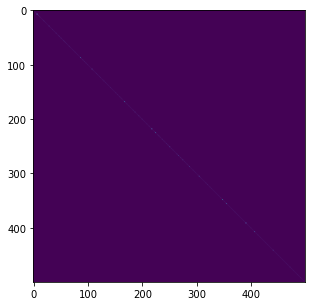

In [8]:
L_arithmetic = np.mean(L, axis=2)

plt.figure(figsize=(5,5))
plt.imshow(L_arithmetic)
plt.show()

In [9]:
print_evaluation(labels, L_arithmetic, K);

Accuracy 0.896 Purity 0.896 NMI 0.7477906112598245 RI 0.7568062007460111


## -- Geometric mean

In [10]:
import pyriemann

In [11]:
L_reg = np.zeros((S, n, n))

for i in range(S):
    L_reg[i,:,:] = L[:,:,i] + 0.001*np.eye(n)
    
L_geometric_mean = pyriemann.utils.mean.mean_riemann(L_reg)

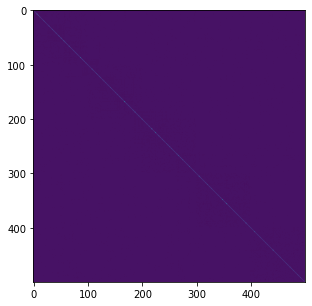

In [12]:
plt.figure(figsize=(5,5))
plt.imshow(L_geometric_mean)
plt.show()

In [13]:
print_evaluation(labels, L_geometric_mean, K);

Accuracy 0.92 Purity 0.92 NMI 0.7975573757848835 RI 0.8097084145708032


In [30]:
adj[:,:,0].min()

0.0

In [31]:
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])